In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Loading Dataset (Data Loading)
df = pd.read_csv("Data_Train.csv")

# Basic Summary Statistics (Data Exploration)
print(df.describe())  # Summary statistics for numerical columns

              Price
count  10683.000000
mean    9087.064121
std     4611.359167
min     1759.000000
25%     5277.000000
50%     8372.000000
75%    12373.000000
max    79512.000000


In [2]:
print(df.info()) # Information about data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
None


In [3]:
# Checking for missing values
print(df.isnull().sum())  # Counting missing values for each column

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


In [4]:
# Checking data types and unique values for categorical columns
print(df['Airline'].value_counts())

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64


In [5]:
print(df['Source'].value_counts())

Source
Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64


In [6]:
print(df['Destination'].value_counts())

Destination
Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64


In [7]:
# Converting 'Date_of_Journey' to datetime (Data cleaning)
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')

# Converting 'Dep_Time' to datetime (Assuming that the departure happens on Date_of_Journey)
df['Dep_Time'] = pd.to_datetime(df['Date_of_Journey'].astype(str) + " " + df['Dep_Time'], format='%Y-%m-%d %H:%M')

# Function to handle inconsistent 'Arrival_Time' formats
from dateutil import parser

def process_arrival_time(row):
    arrival = row['Arrival_Time'].strip()
    
    try:
        # parsing as full datetime
        return pd.to_datetime(arrival, format='%d/%m/%Y %H:%M')
    except ValueError:
        pass  # If it fails, then it proceed to next step

    try:
        # If only time is provided, assume same day as departure
        return pd.to_datetime(f"{row['Date_of_Journey'].strftime('%Y-%m-%d')} {arrival}", format='%Y-%m-%d %H:%M')
    except ValueError:
        pass  # If it fails, then it proceed to next step

    try:
        # If the format is like "HH:MM dd MMM", try parsing it with dateutil
        parsed_dt = parser.parse(arrival, dayfirst=True)
        return pd.to_datetime(f"{row['Date_of_Journey'].year}-{parsed_dt.strftime('%m-%d')} {parsed_dt.strftime('%H:%M')}")
    except ValueError:
        raise ValueError(f"Unrecognized format in Arrival_Time: {arrival}")

# Applying function
df['Arrival_Time'] = df.apply(process_arrival_time, axis=1)


# Extracting useful features from date and time (Feature Engineering)
df['Journey_Day'] = df['Date_of_Journey'].dt.day
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df['Dep_Hour'] = df['Dep_Time'].dt.hour
df['Dep_Minute'] = df['Dep_Time'].dt.minute
df['Arrival_Hour'] = df['Arrival_Time'].dt.hour
df['Arrival_Minute'] = df['Arrival_Time'].dt.minute

# Droping original datetime columns
df.drop(columns=['Date_of_Journey', 'Dep_Time', 'Arrival_Time'], inplace=True)

# Processing 'Duration' into numerical values
df['Duration_Hours'] = df['Duration'].str.extract(r'(\d+)h', expand=False).astype(float).fillna(0)
df['Duration_Minutes'] = df['Duration'].str.extract(r'(\d+)m', expand=False).astype(float).fillna(0)
df['Total_Duration_Minutes'] = df['Duration_Hours'] * 60 + df['Duration_Minutes']
df.drop(columns=['Duration', 'Duration_Hours', 'Duration_Minutes'], inplace=True)
df

Airline    Source Destination                  Route Total_Stops  \
0           IndiGo  Banglore   New Delhi              BLR → DEL    non-stop   
1        Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR     2 stops   
2      Jet Airways     Delhi      Cochin  DEL → LKO → BOM → COK     2 stops   
3           IndiGo   Kolkata    Banglore        CCU → NAG → BLR      1 stop   
4           IndiGo  Banglore   New Delhi        BLR → NAG → DEL      1 stop   
...            ...       ...         ...                    ...         ...   
10678     Air Asia   Kolkata    Banglore              CCU → BLR    non-stop   
10679    Air India   Kolkata    Banglore              CCU → BLR    non-stop   
10680  Jet Airways  Banglore       Delhi              BLR → DEL    non-stop   
10681      Vistara  Banglore   New Delhi              BLR → DEL    non-stop   
10682    Air India     Delhi      Cochin  DEL → GOI → BOM → COK     2 stops   

      Additional_Info  Price  Journey_Day  Journey_Month  Dep_Hour  \
0             No info   3897           24              3        22   
1             No info   7662            1              5         5   
2             No info  13882            9              6         9   
3             No info   6218           12              5        18   
4             No info  13302            1              3        16   
...               ...    ...          ...            ...       ...   
10678         No info   4107            9              4        19   
10679         No info   4145           27              4        20   
10680         No info   7229           27              4         8   
10681         No info  12648            1              3        11   
10682         No info  11753            9              5        10   

       Dep_Minute  Arrival_Hour  Arrival_Minute  Total_Duration_Minutes  
0              20             1              10                   170.0  
1              50            13              15                   445.0  
2              25             4              25                  1140.0  
3               5            23              30                   325.0  
4              50            21              35                   285.0  
...           ...           ...             ...                     ...  
10678          55            22              25                   150.0  
10679          45            23              20                   155.0  
10680          20            11              20                   180.0  
10681          30            14              10                   160.0  
10682          55            19              15                   500.0  

[10683 rows x 14 columns]

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, bins=10)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Scatter plot for numerical feature relationships (e.g., Flight Duration vs Price)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total_Duration_Minutes', y='Price', hue='Airline', palette='Set1')
plt.title('Flight Duration vs. Price')
plt.xlabel('Total Duration (Minutes)')
plt.ylabel('Price')
plt.show()

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Total_Stops', y='Price', data=df)
plt.title('Total Stops vs. Price')
plt.xlabel('Total Stops')
plt.ylabel('Price')
plt.show()

In [11]:
source_dest = df.groupby(['Source', 'Destination']).size().reset_index(name='Count')
plt.figure(figsize=(10, 5))
sns.barplot(x='Count', y='Source', hue='Destination', data=source_dest, orient='h')
plt.title('Source to Destination Frequency')
plt.xlabel('Number of Flights')
plt.ylabel('Source')
plt.show()

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Total_Stops', y='Total_Duration_Minutes', data=df)
plt.title('Journey Duration vs. Number of Stops')
plt.xlabel('Total Stops')
plt.ylabel('Duration (Minutes)')
plt.show()

In [13]:
# Defining categorical and numerical features
categorical_features = ['Airline', 'Source', 'Destination', 'Total_Stops']
numerical_features = ['Journey_Day', 'Journey_Month', 'Dep_Hour', 'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute', 'Total_Duration_Minutes']

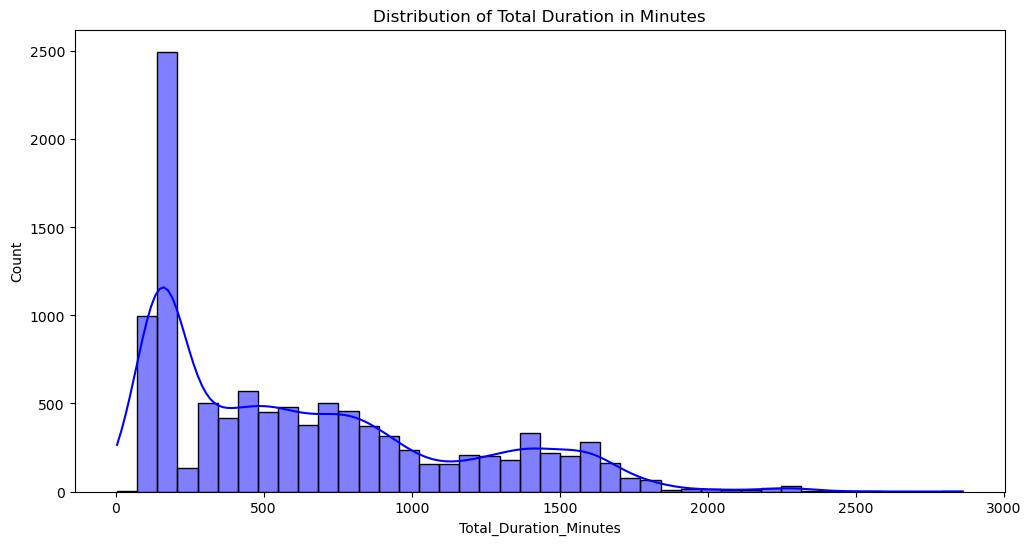

In [14]:
# Histogram for numerical features (e.g., 'Total_Duration_Minutes', 'Price') (Data visualization)
plt.figure(figsize=(12, 6))
sns.histplot(df['Total_Duration_Minutes'], kde=True, color='blue')
plt.title('Distribution of Total Duration in Minutes')
plt.show()

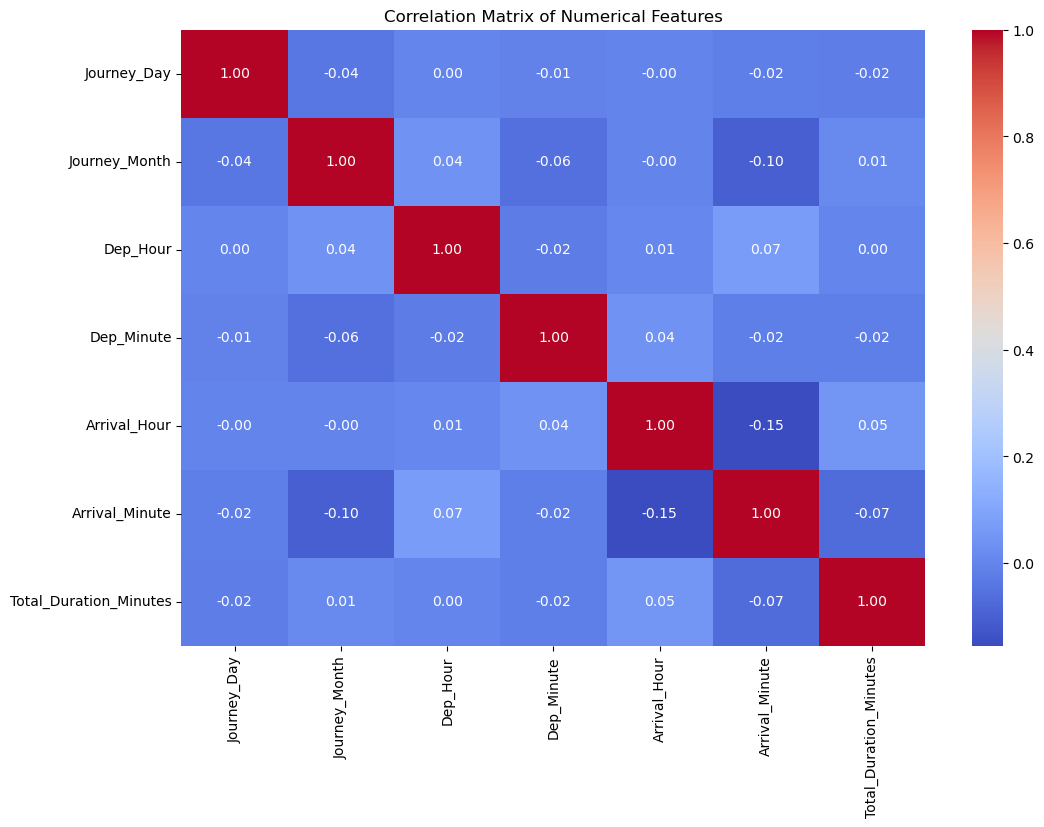

In [15]:
# Correlation Heatmap for numerical features (find relationships)
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

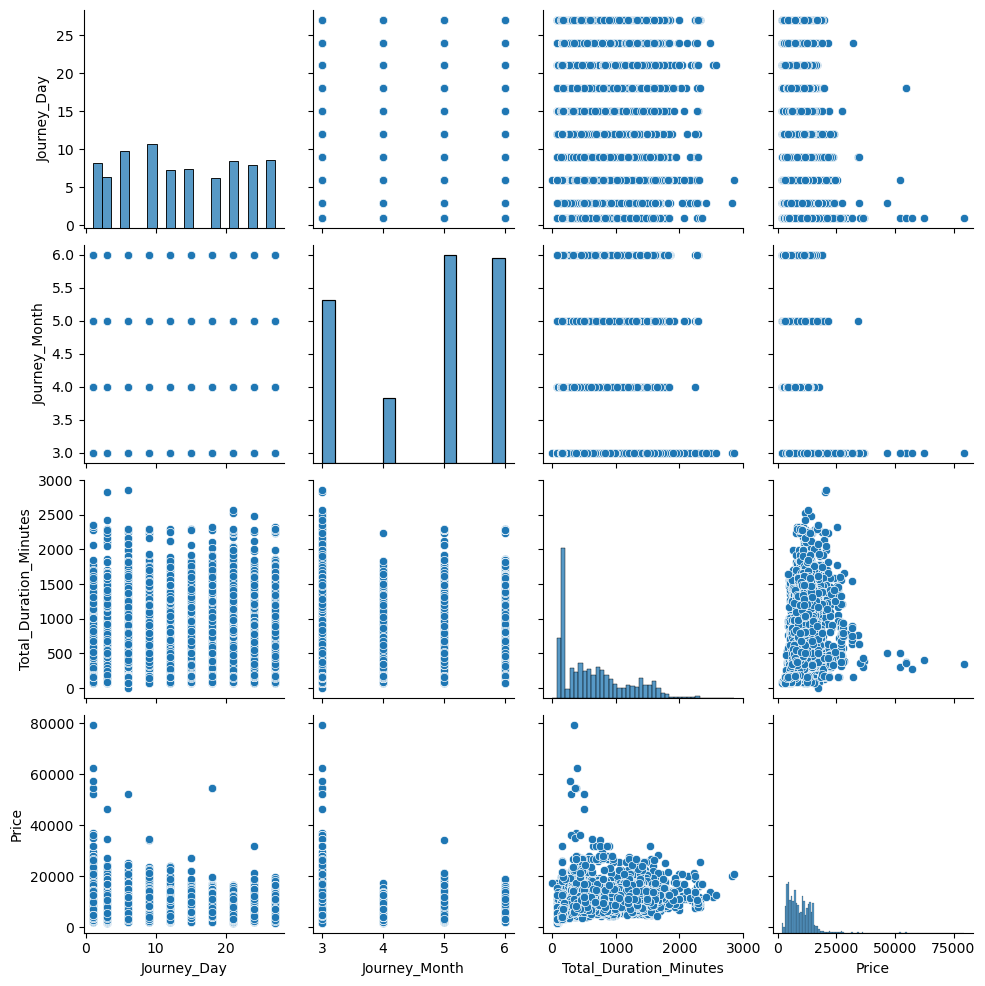

In [16]:
# Pairplot for relationships between key features and the target 'Price'
sns.pairplot(df, vars=['Journey_Day', 'Journey_Month', 'Total_Duration_Minutes', 'Price'], kind='scatter')
plt.show()

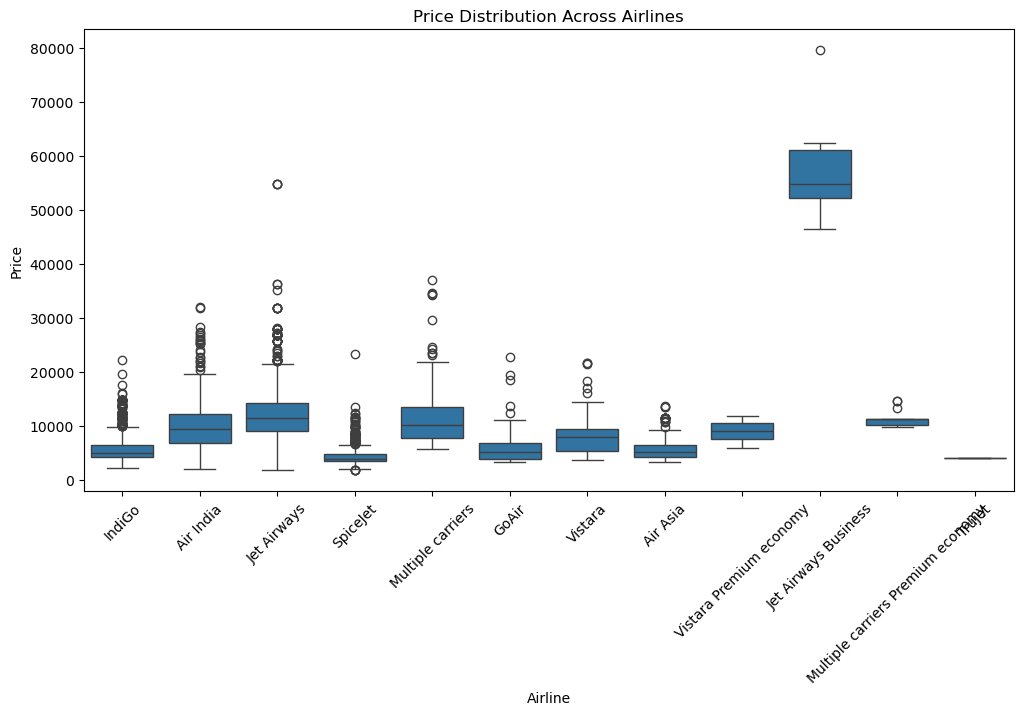

In [17]:
# Boxplot for categorical features vs Price (to see if there's a pattern)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Airline', y='Price', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution Across Airlines')
plt.show()

In [18]:
# Preprocessing pipeline (Data preprocessing)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Defining input (X) and target (y)
X = df.drop(columns=['Price'])
y = df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Linear Regression (Models Training)
linear_regressor = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
linear_regressor.fit(X_train, y_train)
linear_predictions = linear_regressor.predict(X_test)
print("Linear Regression Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, linear_predictions))) # prediction and evaluation
print("R² Score:", r2_score(y_test, linear_predictions))
print("MAPE:", mean_absolute_percentage_error(y_test, linear_predictions))

Linear Regression Performance:
RMSE: 2843.2036825663768
R² Score: 0.6180391161424377
MAPE: 0.23884136519797292


In [20]:
# Random Forest Regressor
rf_regressor = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_regressor.fit(X_train, y_train)
rf_predictions = rf_regressor.predict(X_test)
print("Random Forest Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_predictions)))
print("R² Score:", r2_score(y_test, rf_predictions))
print("MAPE:", mean_absolute_percentage_error(y_test, rf_predictions))

Random Forest Performance:
RMSE: 2012.4012215406942
R² Score: 0.8086484042828264
MAPE: 0.13024752920378668


In [21]:
# XGBoost Regressor
xgb_regressor = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
])
xgb_regressor.fit(X_train, y_train)
xgb_predictions = xgb_regressor.predict(X_test)
print("XGBoost Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, xgb_predictions)))
print("R² Score:", r2_score(y_test, xgb_predictions))
print("MAPE:", mean_absolute_percentage_error(y_test, xgb_predictions))

XGBoost Performance:
RMSE: 1866.5073534126723
R² Score: 0.8353876730298114
MAPE: 0.1285277037972084


In [22]:
# Neural Network Model
def build_nn(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

nn_model = build_nn(X_train_transformed.shape[1])
nn_model.fit(X_train_transformed, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
nn_predictions = nn_model.predict(X_test_transformed)
print("Neural Network Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, nn_predictions)))
print("R² Score:", r2_score(y_test, nn_predictions))
print("MAPE:", mean_absolute_percentage_error(y_test, nn_predictions))

Epoch 1/50


C:\Users\priya\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 104019968.0000 - mae: 9070.0654 - val_loss: 96010728.0000 - val_mae: 8825.4121
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86458792.0000 - mae: 8173.8369 - val_loss: 55616624.0000 - val_mae: 6310.3267
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46527212.0000 - mae: 5265.5381 - val_loss: 16700883.0000 - val_mae: 2855.7180
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19322752.0000 - mae: 2694.8530 - val_loss: 10280511.0000 - val_mae: 2300.2727
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13237408.0000 - mae: 2370.4270 - val_loss: 9421182.0000 - val_mae: 2211.1204
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13244764.0000 - mae: 2311.5842 - val_loss: 8937145.0000 - val_mae: 2137.7571
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11108185.0000 - mae: 2203.0564 - val_loss: 8564135.0000 - val_mae: 2078.5505
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

In [23]:
from sklearn.metrics import mean_absolute_error

# Creating a dictionary to store the results
results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, linear_predictions)),
        np.sqrt(mean_squared_error(y_test, rf_predictions)),
        np.sqrt(mean_squared_error(y_test, xgb_predictions)),
        np.sqrt(mean_squared_error(y_test, nn_predictions))
    ],
    'R² Score': [
        r2_score(y_test, linear_predictions),
        r2_score(y_test, rf_predictions),
        r2_score(y_test, xgb_predictions),
        r2_score(y_test, nn_predictions)
    ],
    'MAPE': [
        mean_absolute_percentage_error(y_test, linear_predictions),
        mean_absolute_percentage_error(y_test, rf_predictions),
        mean_absolute_percentage_error(y_test, xgb_predictions),
        mean_absolute_percentage_error(y_test, nn_predictions)
    ],
    'Accuracy': [
        1 - (mean_absolute_error(y_test, linear_predictions) / y_test.mean()),  # Similar to accuracy
        1 - (mean_absolute_error(y_test, rf_predictions) / y_test.mean()), 
        1 - (mean_absolute_error(y_test, xgb_predictions) / y_test.mean()), 
        1 - (mean_absolute_error(y_test, nn_predictions) / y_test.mean()) 
    ] # Accuracy = 1−(Mean of Actual Values/Mean Absolute Error)
}

# Creating a DataFrame from the dictionary
metrics_df = pd.DataFrame(results)

# Displaying the results table
print(metrics_df)

               Model         RMSE  R² Score      MAPE  Accuracy
0  Linear Regression  2843.203683  0.618039  0.238841  0.782908
1      Random Forest  2012.401222  0.808648  0.130248  0.871354
2            XGBoost  1866.507353  0.835388  0.128528  0.874244
3     Neural Network  2936.878917  0.592456  0.223207  0.787882


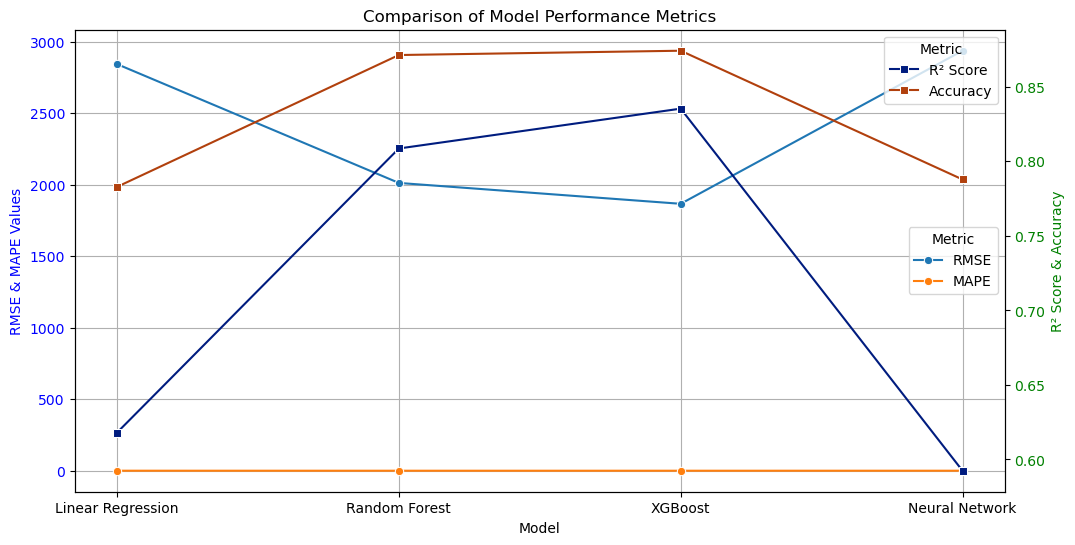

In [72]:
# Melting the DataFrame for easier plotting
metrics_melted = metrics_df.melt(id_vars=['Model'], var_name='Metric', value_name='Value')

# Separating metrics based on scale
metrics_high = metrics_melted[metrics_melted['Metric'].isin(['RMSE', 'MAPE'])]  # Higher scale metrics
metrics_low = metrics_melted[metrics_melted['Metric'].isin(['R² Score', 'Accuracy'])]  # Lower scale metrics

# Creating figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Ploting RMSE and MAPE on the primary Y-axis
sns.lineplot(data=metrics_high, x='Model', y='Value', hue='Metric', marker='o', ax=ax1)
ax1.set_ylabel("RMSE & MAPE Values", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating a second Y-axis
ax2 = ax1.twinx()

# Ploting R² Score and Accuracy on the secondary Y-axis
sns.lineplot(data=metrics_low, x='Model', y='Value', hue='Metric', marker='s', ax=ax2, palette='dark')
ax2.set_ylabel("R² Score & Accuracy", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Setting title and labels
ax1.set_title('Comparison of Model Performance Metrics')
ax1.set_xlabel('Model')
plt.xticks(rotation=45)
ax1.grid(True)

# Showing the plot
plt.show()